In [64]:
import numpy as np

np.random.seed(42)


class BernoulliBandit:
    def __init__(self, K):
        self.probs = np.random.rand(K)
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K

    def step(self, k):
        return (np.random.rand() < self.probs[k]).astype(int)


class Solver:
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(bandit.K)
        self.regret = 0
        self.actions = []
        self.regrets = []

    def update_regret(self, k):
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        raise NotImplementedError

    def run(self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

epsilon-greedy: 28.489221136817044


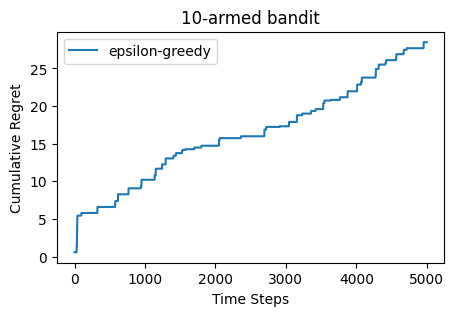

In [65]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (5, 3)


class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * bandit.K)

    def run_one_step(self):
        if np.random.rand() < self.epsilon:
            k = np.random.randint(self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k


def plot_results(solvers, solver_names):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel("Time Steps")
    plt.ylabel("Cumulative Regret")
    plt.title("%d-armed bandit" % solvers[0].bandit.K)
    plt.legend()
    plt.show()


epsilon_greedy_solver = EpsilonGreedy(BernoulliBandit(10), epsilon=0.01)
epsilon_greedy_solver.run(5000)
print(f"epsilon-greedy: {epsilon_greedy_solver.regret}")
plot_results([epsilon_greedy_solver], ["epsilon-greedy"])

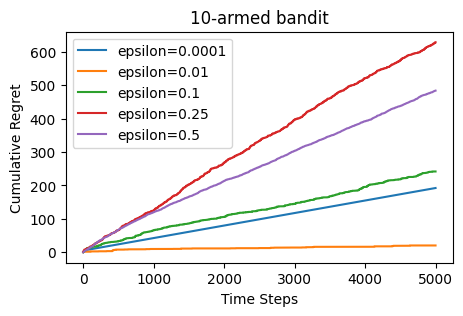

In [66]:
epsilons = [1e-4, 1e-2, 0.1, 0.25, 0.5]
epsilon_greedy_solvers = [
    EpsilonGreedy(BernoulliBandit(10), epsilon=eps) for eps in epsilons
]
epsilon_greedy_solver_names = [f"epsilon={eps}" for eps in epsilons]
for solver in epsilon_greedy_solvers:
    solver.run(5000)

plot_results(epsilon_greedy_solvers, epsilon_greedy_solver_names)

decaying epsilon-greedy: 8.538027140821889


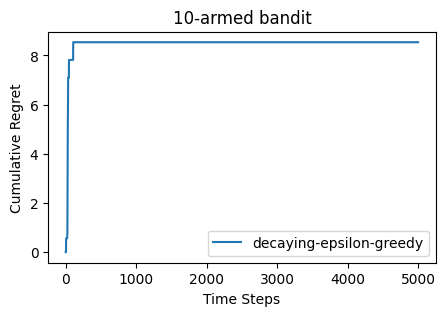

In [67]:
class DecayingEpsilonGreedy(Solver):
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * bandit.K)
        self.total_counts = 0

    def run_one_step(self):
        self.total_counts += 1
        if np.random.random() < 1.0 / self.total_counts:
            k = np.random.randint(self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k


decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(BernoulliBandit(10))
decaying_epsilon_greedy_solver.run(5000)
print(f"decaying epsilon-greedy: {decaying_epsilon_greedy_solver.regret}")
plot_results([decaying_epsilon_greedy_solver], ["decaying-epsilon-greedy"])

In [69]:
import numpy as np

np.random.seed(0)
# 定义状态转移概率矩阵P
P = [
    [0.9, 0.1, 0.0, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.6, 0.0, 0.4],
    [0.0, 0.0, 0.0, 0.0, 0.3, 0.7],
    [0.0, 0.2, 0.3, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
]
P = np.array(P)

rewards = [-1, -2, -2, 10, 1, 0]  # 定义奖励函数
gamma = 0.5  # 定义折扣因子


# 给定一条序列,计算从某个索引（起始状态）开始到序列最后（终止状态）得到的回报
def compute_return(start_index, chain, gamma):
    G = 0
    for i in reversed(range(start_index, len(chain))):
        G = gamma * G + rewards[chain[i] - 1]
    return G


# 一个状态序列,s1-s2-s3-s6
chain = [1, 2, 3, 6]
start_index = 0
G = compute_return(start_index, chain, gamma)
print("根据本序列计算得到回报为：%s。" % G)

根据本序列计算得到回报为：-2.5。


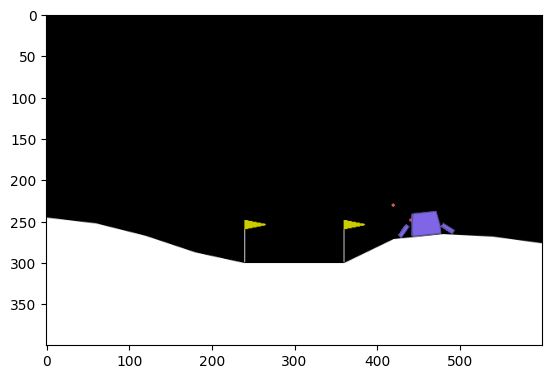

In [13]:
import gymnasium as gym
import matplotlib.pyplot as plt
import os

os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

env = gym.make("LunarLander-v3", render_mode="rgb_array")
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = (
        env.action_space.sample()
    )  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    episode_over = terminated or truncated

env.close()

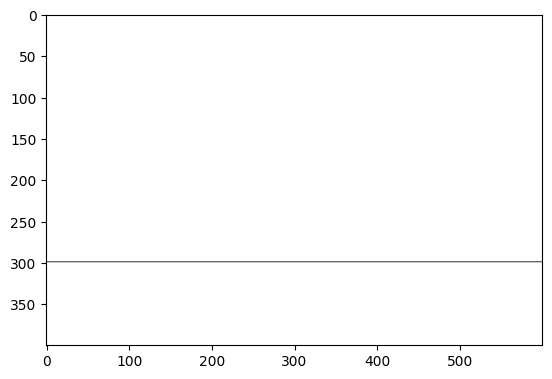

In [18]:
env = gym.make("CartPole-v0", render_mode="rgb_array")  # 构建实验环境
env.reset()  # 重置一个回合
for _ in range(1000):
    env.render()  # 显示图形界面
    action = env.action_space.sample()  # 从动作空间中随机选取一个动作
    env.step(action)  # 用于提交动作，括号内是具体的动作
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
env.close()  # 关闭环境

In [19]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
print("观测空间 = {}".format(env.observation_space))
print("动作空间 = {}".format(env.action_space))
print(
    "观测范围 = {} ~ {}".format(env.observation_space.low, env.observation_space.high)
)
print("动作数 = {}".format(env.action_space.n))

观测空间 = Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
动作空间 = Discrete(3)
观测范围 = [-1.2  -0.07] ~ [0.6  0.07]
动作数 = 3
